In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftn, ifftn, fftfreq, fftshift
from scipy.stats import binned_statistic
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def read_npy(paths,sep=2):
    npys = []
    for i,path in enumerate(paths):
        npys.append(np.load(path))
        if i % sep == 0:
            print(f'{i}:Loading {path} {npys[-1].shape}')
    print(f'Total of {len(npys)} files loaded')
    return npys

In [3]:
!ls ~/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy

/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy


In [4]:
!ls ~/ceph/mldust-ver2/data/npy-kdrive3-8/TurbPar.out2.00010.hdf5-vp.npy

/mnt/home/tchan1/ceph/mldust-ver2/data/npy-kdrive3-8/TurbPar.out2.00010.hdf5-vp.npy


In [5]:
vg_normal = read_npy(['/mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy'])[0]
vg_kdrive = read_npy(['/mnt/home/tchan1/ceph/mldust-ver2/data/npy-kdrive3-8/TurbPar.out2.00010.hdf5-vp.npy'])[0]

0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy/TurbPar.out2.00103.hdf5-vel.npy (3, 256, 256, 256)
Total of 1 files loaded
0:Loading /mnt/home/tchan1/ceph/mldust-ver2/data/npy-kdrive3-8/TurbPar.out2.00010.hdf5-vp.npy (3, 256, 256, 256)
Total of 1 files loaded


In [6]:
dx = 1/256
dV = dx*dx*dx

In [7]:
vg_normal.shape,vg_kdrive.shape

((3, 256, 256, 256), (3, 256, 256, 256))

In [8]:
np.sum(vg_normal**2)*dV, np.sum(vg_kdrive**2)*dV

(0.03235923498868942, 0.012164151296019554)

In [9]:
def power_spec(vg):
    freq = fftfreq(256,1/256)
    fx,fy,fz = np.meshgrid(freq,freq,freq)
    f = np.sqrt(fx**2 + fy**2 + fz**2)
    freqBins = np.geomspace(np.min(f)+0.5,np.max(f),20+1)
    powers = []
    #raw_powers = []
    for i in range(3):
        spectrum = fftn(vg[i])*dV
        spectrum = np.real(spectrum*np.conjugate(spectrum))
        powers.append(spectrum)
        #raw_powers.append(spectrum)
    
    powers = np.stack(powers)
    print(powers.shape)
    powers = np.sum(powers, axis=0)
    print(powers.shape)
    print('Total power before binning: ',np.sum(powers))
    powers, binEdges, _ = binned_statistic(f.flatten(),powers.flatten(), statistic='sum',bins=freqBins)
        
    binCenters = np.sqrt(binEdges[1:]*binEdges[:-1])
    print('Total powre after binning: ',np.sum(powers*(binEdges[1:]-binEdges[:-1])))
    return {'freqCenters':binCenters, 'power':powers, 'freqEdges':binEdges}

In [10]:
normal_spec =  power_spec(vg_normal)

(3, 256, 256, 256)
(256, 256, 256)
Total power before binning:  0.03235923397547089
Total powre after binning:  0.07691537719184367


In [11]:
kdrive_spec = power_spec(vg_kdrive)

(3, 256, 256, 256)
(256, 256, 256)
Total power before binning:  0.01216416732251286
Total powre after binning:  0.05872118213600986


In [12]:
#freqCenter.shape, power.shape, freqEdges.shape

In [13]:
#np.sum(freqCenter*power*(freqEdges[1:]-freqEdges[:-1]))

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

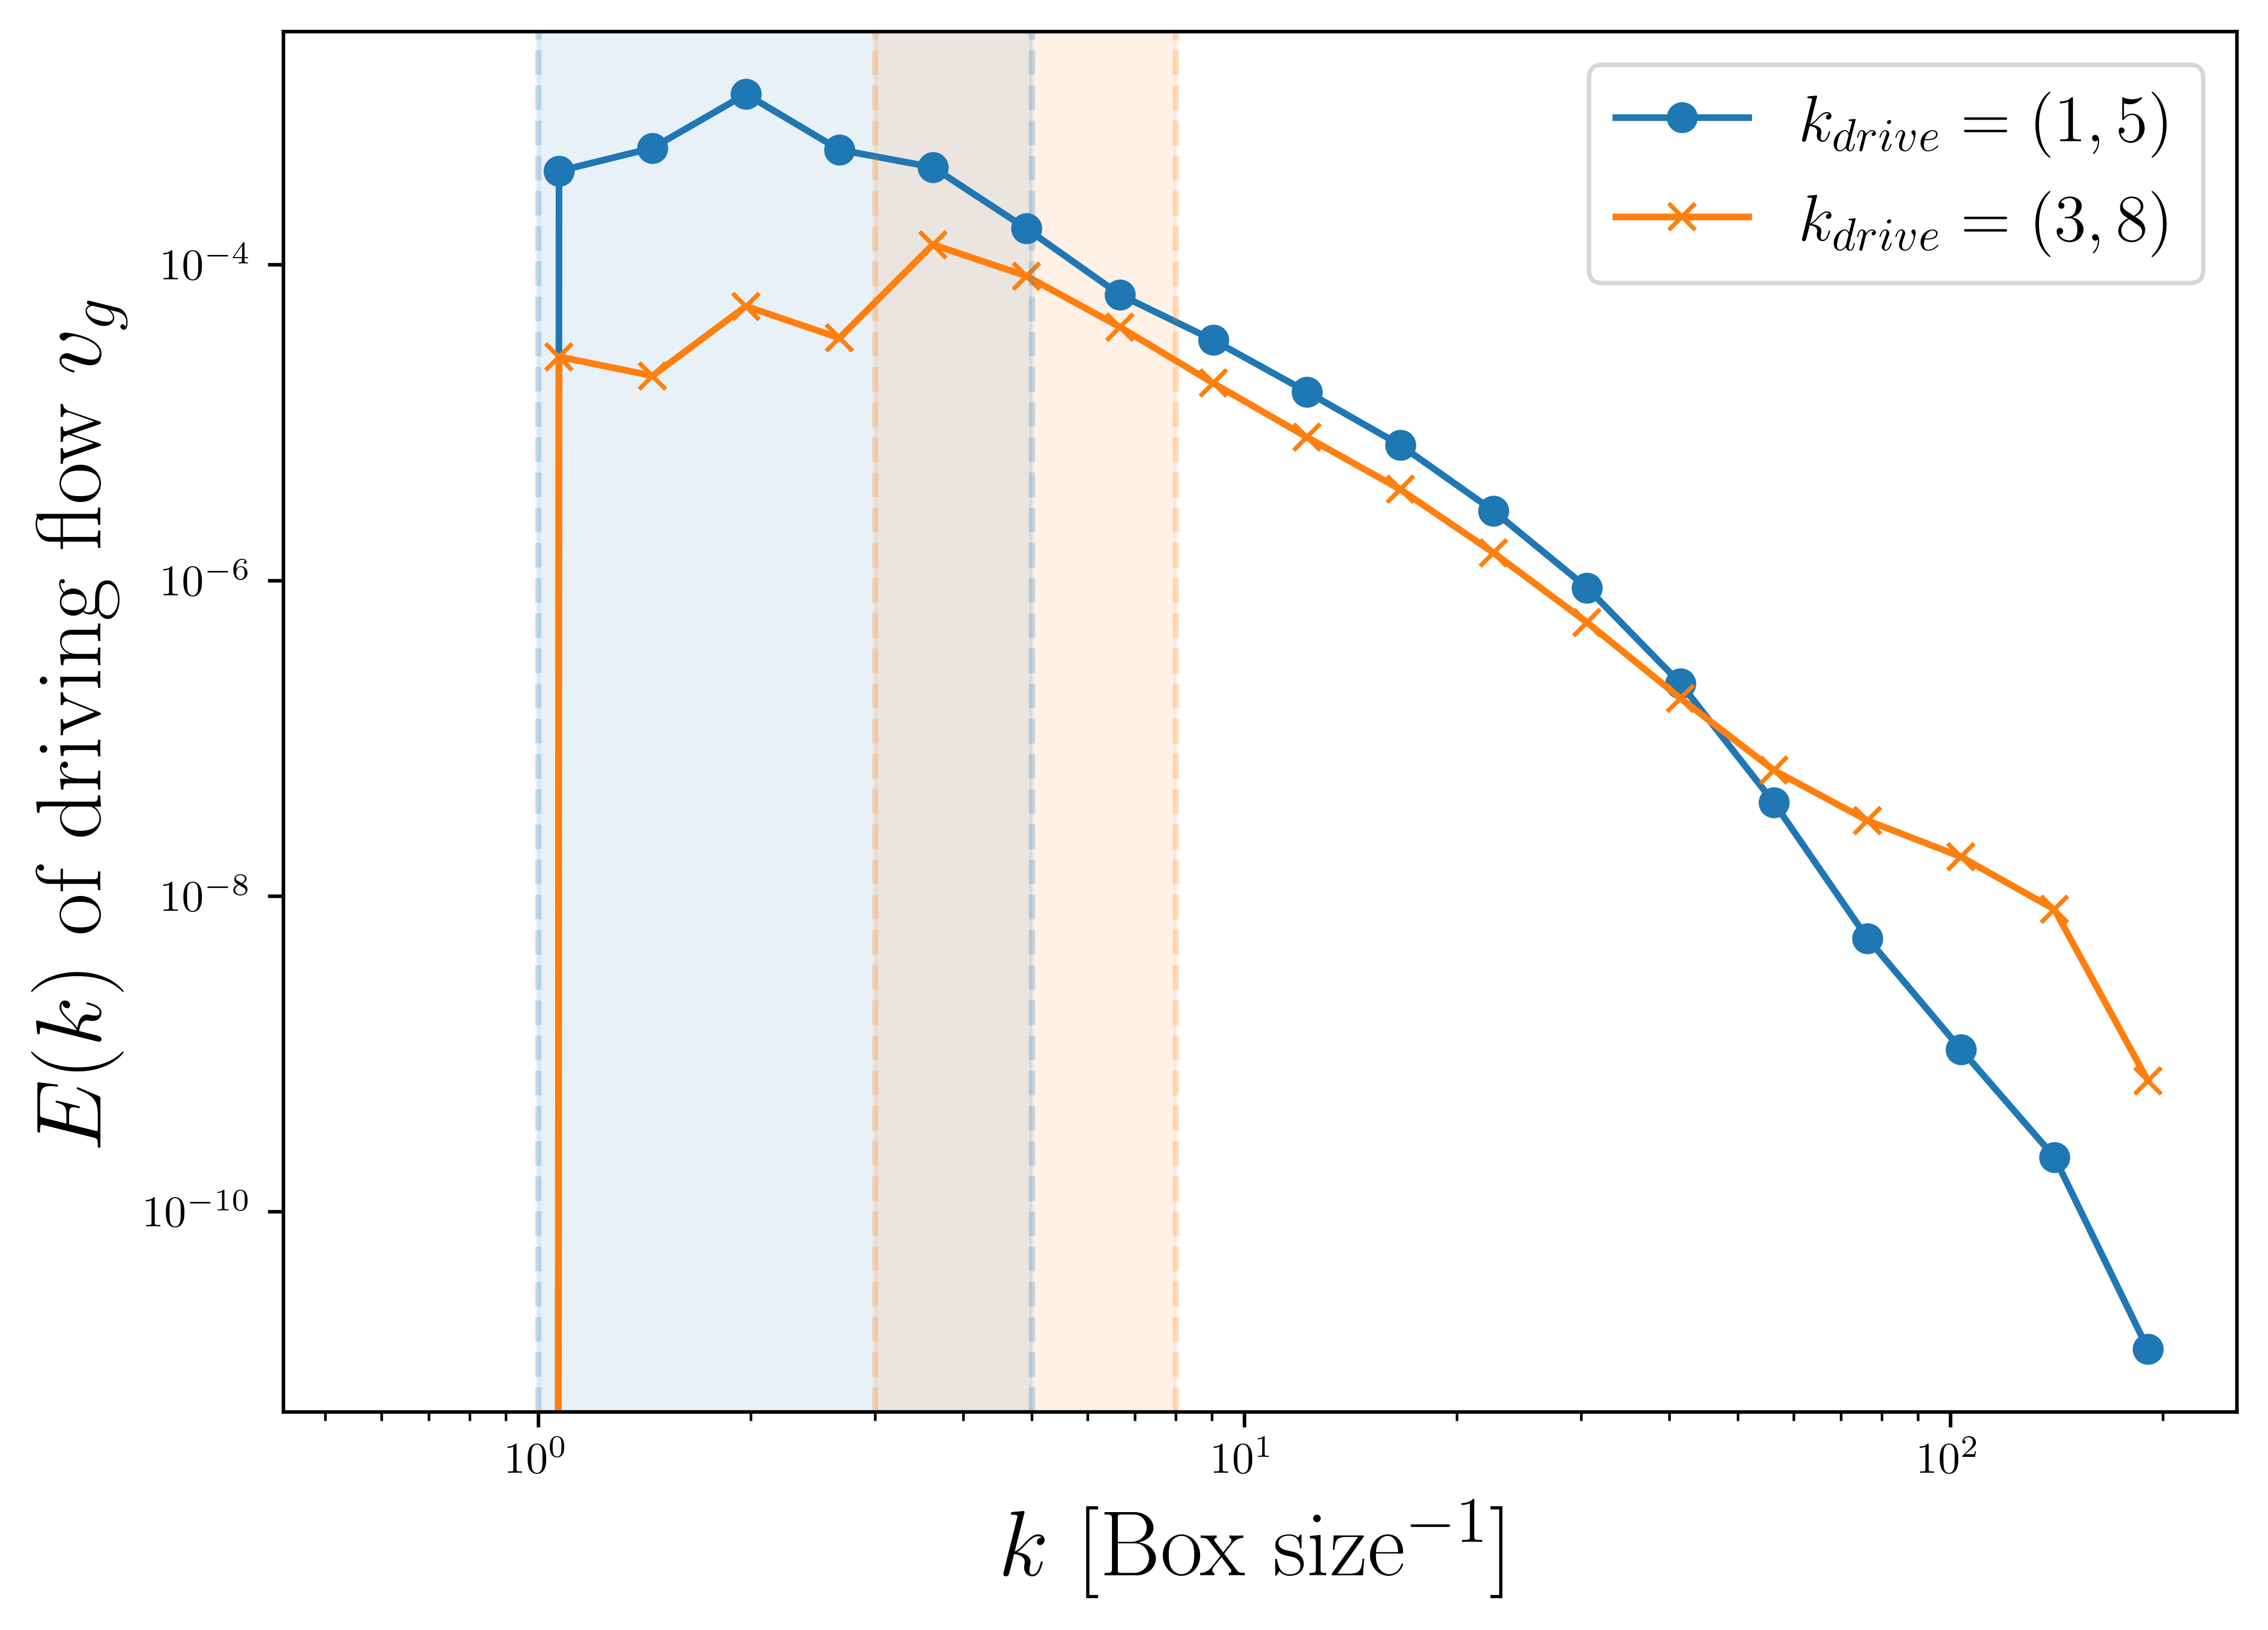

In [20]:
with PdfPages('vg_power_spectrum.pdf') as pdf:
    fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(7,5),dpi=600,constrained_layout=True)

    axs.loglog(normal_spec['freqCenters'],normal_spec['power']/normal_spec['freqCenters']**2,ls='-',marker='o',label=r'$k_{drive}=(1,5)$')
    axs.loglog(kdrive_spec['freqCenters'],kdrive_spec['power']/kdrive_spec['freqCenters']**2,ls='-',marker='x',label=r'$k_{drive}=(3,8)$')
    axs.set_xlabel(r'$k$ [Box size$^{-1}$]',fontsize=21)
    axs.set_ylabel(r'$E(k)$ of driving flow $v_g$',fontsize=21)
    axs.axvline(1,color='tab:blue',ls='--',alpha=0.2)
    axs.axvline(5,color='tab:blue',ls='--',alpha=0.2)

    axs.axvline(3,color='tab:orange',ls='--',alpha=0.2)
    axs.axvline(8,color='tab:orange',ls='--',alpha=0.2)

    #axs.set_title(r'Energy spectrum of $v_g$',fontsize=21)

    yl,yh = plt.gca().get_ylim()
    axs.set_ylim(yl,yh)

    x15 = np.linspace(1,5)
    x38 = np.linspace(3,8)
    axs.fill_between(x15,yl,yh,color='tab:blue',alpha=0.1)
    axs.fill_between(x38,yl,yh,color='tab:orange',alpha=0.1)
    axs.legend(fontsize=15)
    pdf.savefig(fig)

# 